# Import libraries

In [1]:
import numpy as np
import os
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
from tqdm import tqdm
import pandas as pd

# Dataset analysis

Train images: 14034
Test images: 3000
Test percentage: 18%


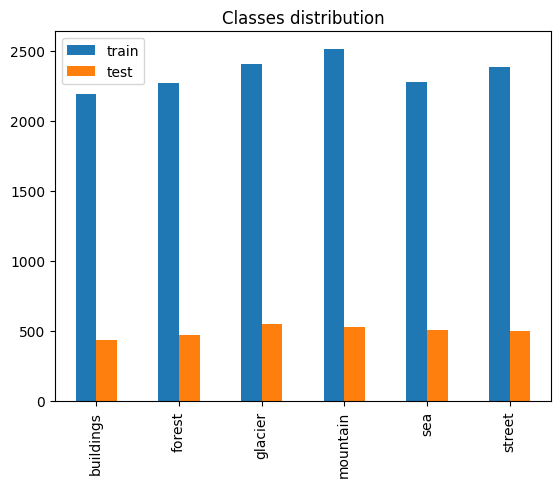

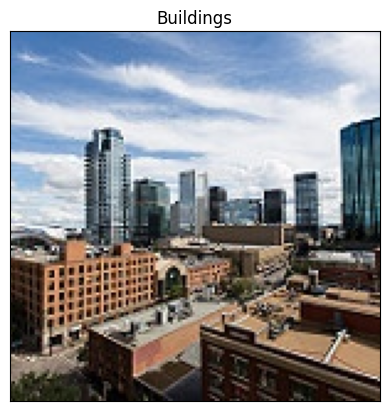

In [2]:
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street" ]
train_counts = []
test_counts = []

for class_name in class_names:
    path = "data/train/" + class_name
    num_images = 0
    for _, _, files in os.walk(path):
        num_images += len(files)
    train_counts.append(num_images)
    
    path = "data/test/" + class_name
    num_images = 0
    for _, _, files in os.walk(path):
        num_images += len(files)
    test_counts.append(num_images)
train_counts = np.array(train_counts)
test_counts = np.array(test_counts)

num_train = np.sum(train_counts)
num_test = np.sum(test_counts)
test_percentage = round(num_test / (num_train+num_test) * 100)
print("Train images: " + str(num_train))
print("Test images: " + str(num_test))
print("Test percentage: " + str(test_percentage) + "%")

counts = {"train": train_counts, "test": test_counts}
pd.DataFrame(counts, index=class_names).plot.bar() 
plt.title("Classes distribution")
plt.show()

image = cv2.imread("data/train/buildings/10006.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (150,150))
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title("Buildings")
plt.show()

# Load data

In [3]:
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street" ]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

def load_images(folder_path, max_images=1000000, target_size=(150,150)):
    print("Loading " + folder_path)
    images = []
    labels = []
    images_per_folder = int(max_images / 6) # rounds down
    
    for folder in os.listdir(folder_path):
        num_images_loaded_this_folder = 0
        label = class_names_label[folder]
        # Iterate through each image in this folder
        for file in tqdm(os.listdir(os.path.join(folder_path, folder))):
            # Get the path name of the image
            img_path = os.path.join(os.path.join(folder_path, folder), file)
            # Open and resize the img
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size) 
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)
            num_images_loaded_this_folder += 1
            if num_images_loaded_this_folder >= images_per_folder:
                break
                
    print("Loaded " + folder_path)
    return np.array(images, dtype = 'float16'), np.array(labels, dtype = 'int8')

target_size = (75,75)
train_images, train_labels = load_images("data/train", max_images=7000, target_size=target_size)
test_images, test_labels = load_images("data/test", max_images=1750, target_size=target_size)

train_images, train_labels = shuffle(train_images, train_labels, random_state=3)

# Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
test_percentage = (n_test/(n_train+n_test)) * 100

print("Image size:", target_size)
print ("Train images: {}".format(n_train))
print ("Test images: {}".format(n_test))
print("Test percentage: {}%".format(round(test_percentage)))

print("train_images.shape", train_images.shape)
print("train_labels[:10]", train_labels[:10])
print("test_images.shape", test_images.shape)
print("test_labels[:10]", test_labels[:10])

Loading data/train


 53%|█████▎    | 1165/2191 [00:08<00:07, 132.90it/s]


Loaded data/train
Loading data/test


 66%|██████▋   | 290/437 [00:00<00:00, 320.12it/s]


Loaded data/test
Image size: (75, 75)
Train images: 6996
Test images: 1746
Test percentage: 20%
train_images.shape (6996, 75, 75, 3)
train_labels[:10] [1 1 3 1 5 4 1 2 0 0]
test_images.shape (1746, 75, 75, 3)
test_labels[:10] [2 2 2 2 2 2 2 2 2 2]


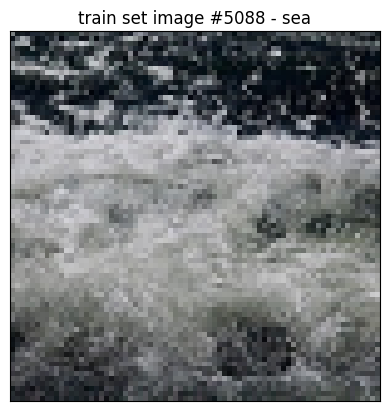

In [4]:
def display_random_image(set="train"):
    images, labels = train_images, train_labels
    if set == "test":
        images, labels = test_images, test_labels
    index = np.random.randint(images.shape[0])
    image = images[index].astype(np.float32)
    plt.figure()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(set + ' set image #' + str(index+1) + " - " + class_names[labels[index]])
    plt.show()
    
display_random_image("train")
#display_random_image("test")

# CNNs

In [5]:
import tensorflow as tf 
#from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

2023-06-15 23:15:57.001686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 23:15:58.242824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 23:15:58.243674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 23:16:06.630677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (target_size[0], target_size[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer="adam", loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
history = model.fit(train_images, train_labels, batch_size=64, epochs=15, validation_split = 0.2)
print("Evaluating on test set...")
evaluation = model.evaluate(test_images, test_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9248)              0         
                                                                 
 dense (Dense)               (None, 128)               1

2023-06-15 23:16:14.116807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377730000 exceeds 10% of free system memory.


Epoch 1/15
88/88 [==============================] - 23s 246ms/step - loss: 1.1967 - accuracy: 0.5363 - val_loss: 0.9191 - val_accuracy: 0.6514
Epoch 2/15
88/88 [==============================] - 20s 231ms/step - loss: 0.8527 - accuracy: 0.6749 - val_loss: 0.7494 - val_accuracy: 0.7307
Epoch 3/15
88/88 [==============================] - 21s 238ms/step - loss: 0.7038 - accuracy: 0.7471 - val_loss: 0.7719 - val_accuracy: 0.7071
Epoch 4/15
88/88 [==============================] - 20s 228ms/step - loss: 0.6124 - accuracy: 0.7759 - val_loss: 0.6623 - val_accuracy: 0.7679
Epoch 5/15
88/88 [==============================] - 20s 232ms/step - loss: 0.5142 - accuracy: 0.8143 - val_loss: 0.6490 - val_accuracy: 0.7750
Epoch 6/15
88/88 [==============================] - 18s 209ms/step - loss: 0.4165 - accuracy: 0.8574 - val_loss: 0.6556 - val_accuracy: 0.7707
Epoch 7/15
88/88 [==============================] - 20s 228ms/step - loss: 0.3419 - accuracy: 0.8899 - val_loss: 0.7067 - val_accuracy: 0.7657

2023-06-15 23:21:26.801165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117855000 exceeds 10% of free system memory.


55/55 [==============================] - 1s 20ms/step - loss: 1.1486 - accuracy: 0.7365


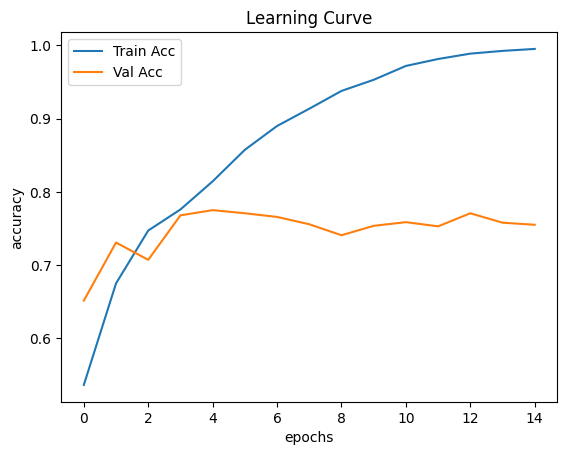

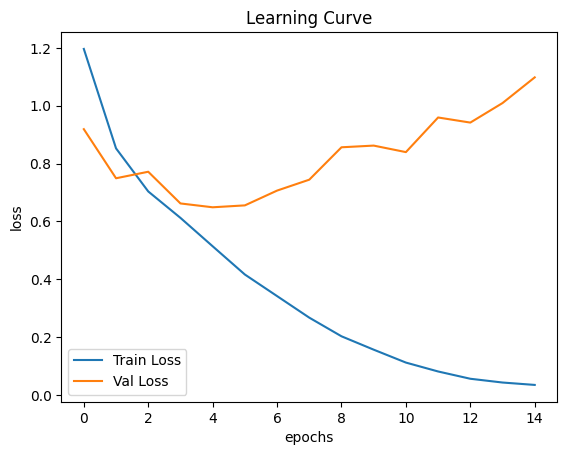

In [7]:
def plot_loss_accuracy(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label = "Train Acc")
    plt.plot(history.history['val_accuracy'], label = "Val Acc")
    plt.title("Learning Curve")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
    # Plot loss function
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Val Loss")
    plt.title("Learning Curve")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

plot_loss_accuracy(history)

2023-06-15 23:21:40.456243: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117855000 exceeds 10% of free system memory.


55/55 [==============================] - 6s 21ms/step


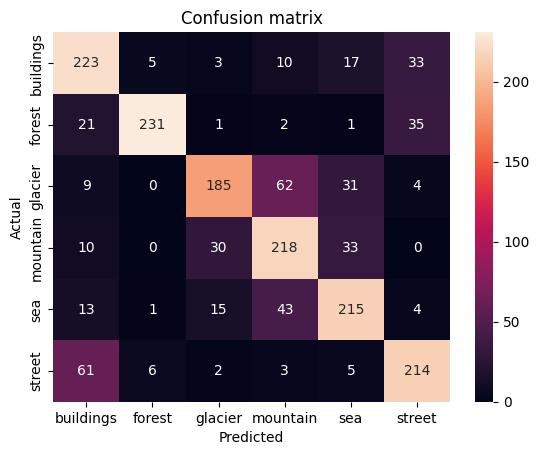

In [8]:
def plot_confusion_matrix(model):
    predictions = model.predict(test_images)     # Vector of probabilities
    pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
    CM = confusion_matrix(test_labels, pred_labels)
    ax = plt.axes()
    sn.heatmap(CM, annot=True, fmt="d",
               annot_kws={"size": 10}, 
               xticklabels=class_names, 
               yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

plot_confusion_matrix(model)

In [9]:
from tensorflow.keras.layers import *
model = tf.keras.Sequential()
model.add(Conv2D(32,(3,3), input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(6,activation ='softmax'))

model.compile(optimizer="adam", loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
history = model.fit(train_images, train_labels, batch_size=64, epochs=15, validation_split = 0.2)
print("Evaluating on test set...")
evaluation = model.evaluate(test_images, test_labels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 9, 64)        

2023-06-15 23:21:50.753460: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377730000 exceeds 10% of free system memory.


Epoch 1/15
88/88 [==============================] - 49s 385ms/step - loss: 1.3907 - accuracy: 0.4176 - val_loss: 1.0217 - val_accuracy: 0.5914
Epoch 2/15
88/88 [==============================] - 33s 374ms/step - loss: 1.0123 - accuracy: 0.6010 - val_loss: 0.8698 - val_accuracy: 0.6614
Epoch 3/15
88/88 [==============================] - 34s 384ms/step - loss: 0.9163 - accuracy: 0.6476 - val_loss: 0.7445 - val_accuracy: 0.7264
Epoch 4/15
88/88 [==============================] - 28s 323ms/step - loss: 0.8021 - accuracy: 0.7016 - val_loss: 0.6992 - val_accuracy: 0.7607
Epoch 5/15
88/88 [==============================] - 27s 309ms/step - loss: 0.7129 - accuracy: 0.7386 - val_loss: 0.6172 - val_accuracy: 0.7757
Epoch 6/15
88/88 [==============================] - 26s 295ms/step - loss: 0.6372 - accuracy: 0.7738 - val_loss: 0.6349 - val_accuracy: 0.7771
Epoch 7/15
88/88 [==============================] - 34s 382ms/step - loss: 0.5825 - accuracy: 0.7981 - val_loss: 0.5880 - val_accuracy: 0.7893

2023-06-15 23:30:21.570260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117855000 exceeds 10% of free system memory.


55/55 [==============================] - 3s 58ms/step - loss: 0.6591 - accuracy: 0.8116


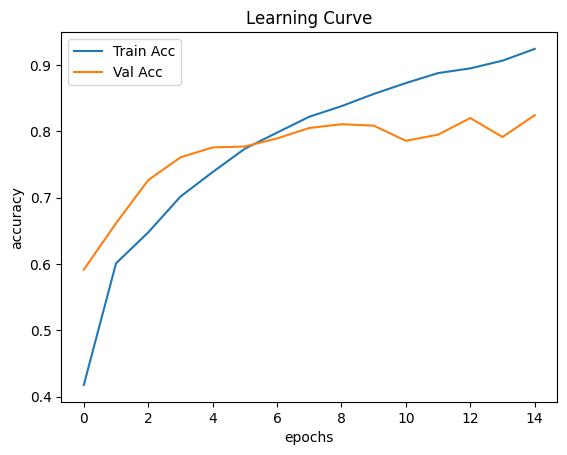

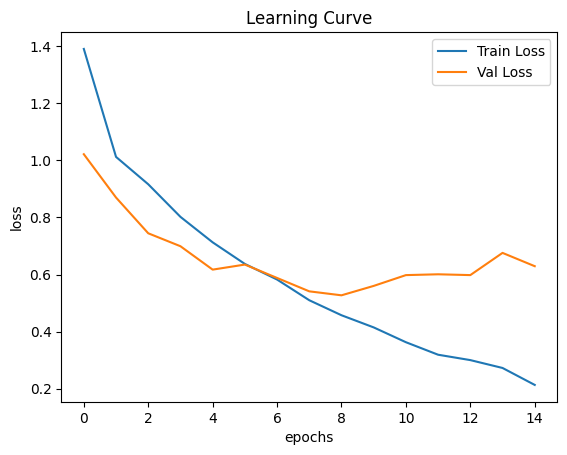

55/55 [==============================] - 9s 39ms/step


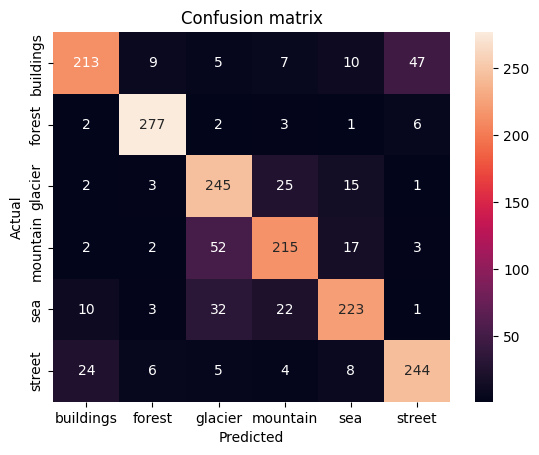

In [10]:
plot_loss_accuracy(history)
plot_confusion_matrix(model)